# Определение перспективного тарифа для телеком компании

## Описание проекта

Предоставлены данные от компании — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: "Смарт" и "Ультра". Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф прибыльнее для компании.

### Описание данных

Таблица users (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Содержание проекта
1. <a href='#step-1'>Открытие данных и изучение общей информации.</a>
2. <a href='#step-2'>Предобработка данных.</a>
3. <a href='#step-3'>Анализ данных.</a>
4. <a href='#step-4'>Проверка гипотез.</a>
5. <a href='#step-5'>Общий вывод.</a>

### <a id='step-1'>Шаг 1. Открытие данных и изучение общей информации.</a> 

In [1]:
# Импортируем нужные библиотеки и изучим общую информацию.
import pandas as pd
import matplotlib as plt
import numpy as np
import math
from scipy import stats as st

calls_data = pd.read_csv('/datasets/calls.csv')
internet_data = pd.read_csv('/datasets/internet.csv', index_col=0)
messages_data = pd.read_csv('/datasets/messages.csv')
tariffs_data = pd.read_csv('/datasets/tariffs.csv')
users_data = pd.read_csv('/datasets/users.csv')

In [2]:
tariffs_data.info()
tariffs_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [3]:
print(f"Количество дубликатов в таблице: {internet_data.duplicated().sum()}")
internet_data.info()
internet_data.head(10)

Количество дубликатов в таблице: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


In [4]:
print(f"Количество дубликатов в таблице: {messages_data.duplicated().sum()}")
messages_data.info()
messages_data.head(10)

Количество дубликатов в таблице: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [5]:
print(f"Количество дубликатов в таблице: {users_data.duplicated().sum()}")
users_data.info()
users_data.head(10)

Количество дубликатов в таблице: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


In [6]:
print(f"Количество дубликатов в таблице: {calls_data.duplicated().sum()}")
calls_data.info()
calls_data.head(10)

Количество дубликатов в таблице: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


#### Вывод
Пропущенных значений в данных, помимо столбца *'churn_rate'* в *users_data*, не наблюдается, как и дубликатов. Необходимо будет перевести столбцы с датами в *datetime* и округлить количество мегабайт в *'mb_used'*, переведя столбец в *int*.

### <a id='step-2'>Шаг 2. Предобработка данных.</a>

In [7]:
# Переведём значения даты в этих датасетах в datetime.
internet_data['session_date'] = pd.to_datetime(internet_data['session_date'], format='%Y-%m-%d')
messages_data['message_date'] = pd.to_datetime(messages_data['message_date'], format='%Y-%m-%d')
users_data['reg_date'] = pd.to_datetime(users_data['reg_date'], format='%Y-%m-%d')
calls_data['call_date'] = pd.to_datetime(calls_data['call_date'], format='%Y-%m-%d')

# Округлим использованные мегабайты, десятые и сотые доли нам не нужны.
internet_data['mb_used'] = internet_data['mb_used'].astype('int')

# Убираем все пропущенные звонки из датасета.
calls_data = calls_data.query('duration > 0')

internet_data.info()
messages_data.info()
users_data.info()
calls_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null int64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff   

In [8]:
# Добавим столбец для месяца в таблицы, и заменим численные значения, появляющиеся
# при использовании функции, на слова.

# Создадим список с месяцами, чтобы использовать его в дальнейшем.
months = ['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']

internet_data['month'] = internet_data['session_date'].dt.month
internet_data['month'] = internet_data['month'].replace(range(1, 13), months)
messages_data['month'] = messages_data['message_date'].dt.month
messages_data['month'] = messages_data['month'].replace(range(1, 13), months)
calls_data['month'] = calls_data['call_date'].dt.month
calls_data['month'] = calls_data['month'].replace(range(1, 13), months)

# Заменим имя столбца для дальнейшего объединения в одну таблицу.
tariffs_data.rename(columns = {'tariff_name' : 'tariff'}, inplace=True)

# Создадим сводные таблицы для подсчёта суммы израсходанного трафика, количества сообщений, 
# длительности звонков и количество звонков за месяц.
internet_month_pivot = internet_data.pivot_table(
    index=['user_id', 'month'], values='mb_used', aggfunc='sum'
).reset_index()
messages_month_pivot = messages_data.pivot_table(
    index=['user_id', 'month'], values='id', aggfunc='count'
).reset_index()
calls_duration_month_pivot = calls_data.pivot_table(
    index=['user_id', 'month'], values='duration', aggfunc='sum'
).reset_index()
calls_count_month_pivot = calls_data.pivot_table(
    index=['user_id', 'month'], values='id', aggfunc='count'
).reset_index()

# Заменим имена столбцов для большей понятности.
messages_month_pivot.rename(columns = {'id' : 'messages_count'}, inplace=True)
calls_count_month_pivot.rename(columns = {'id' : 'calls_count'}, inplace=True)

# Очистим users_data от данных, которые мы не будем использовать.
users_data_cleaned = users_data[['user_id', 'city', 'tariff']]

# Объединим данные в одну таблицу.
data = internet_month_pivot.merge(
    messages_month_pivot, on=['month', 'user_id'], how='left').merge(
    calls_duration_month_pivot, on=['month', 'user_id'], how='left').merge(
    calls_count_month_pivot, on=['month', 'user_id'], how='left').merge(
    users_data_cleaned, on='user_id').merge(tariffs_data, on='tariff')

# Заполним пустые значения нулями, это будет значить, что абоненты не пользовались звонками или сообщениями.
data = data.fillna(0)

# Уберём лишние нули, переведя в int.
data[['messages_count', 'duration', 'calls_count']] = data[['messages_count', 'duration', 'calls_count']].astype('int')
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3203 entries, 0 to 3202
Data columns (total 15 columns):
user_id                  3203 non-null int64
month                    3203 non-null object
mb_used                  3203 non-null int64
messages_count           3203 non-null int64
duration                 3203 non-null int64
calls_count              3203 non-null int64
city                     3203 non-null object
tariff                   3203 non-null object
messages_included        3203 non-null int64
mb_per_month_included    3203 non-null int64
minutes_included         3203 non-null int64
rub_monthly_fee          3203 non-null int64
rub_per_gb               3203 non-null int64
rub_per_message          3203 non-null int64
rub_per_minute           3203 non-null int64
dtypes: int64(12), object(3)
memory usage: 400.4+ KB


,user_id,month,mb_used,messages_count,duration,calls_count,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,Август,14043,81,389,42,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1000,Декабрь,9808,70,312,38,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,1000,Июль,13988,75,318,41,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,1000,Июнь,23213,60,158,28,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,1000,Май,2252,22,150,17,Краснодар,ultra,1000,30720,3000,1950,150,1,1
5,1000,Ноябрь,14745,58,319,37,Краснодар,ultra,1000,30720,3000,1950,150,1,1
6,1000,Октябрь,14690,73,328,44,Краснодар,ultra,1000,30720,3000,1950,150,1,1
7,1000,Сентябрь,14556,57,440,46,Краснодар,ultra,1000,30720,3000,1950,150,1,1
8,1003,Август,8557,37,355,43,Москва,ultra,1000,30720,3000,1950,150,1,1
9,1003,Декабрь,10111,75,755,88,Москва,ultra,1000,30720,3000,1950,150,1,1


In [9]:
# Напишем функцию для подсчёта выручки для пользователя по месяцу.
def count_fee(row):
    """
    Рассчитывает сумму, которую заплатил пользователь.
    Прибавляет к месячной плате за тариф:
    - Разницу между израсходованными минутами и включёнными в тариф минутами, умноженную на 
    - Разницу между израсходованными сообщениями и включёнными в тариф сообщениями.
    - Разницу между израсходованным трафиком и включённым в тариф трафиком.
    Если значение меньше 0, то приравнивается к 0, чтобы избежать отрицательных значений
    в случае, если, например израсходованных минут будет меньше, чем включённых минут.
    Разница округляется вверх.
    """
    sum_minutes = row['duration']
    sum_messages = row['messages_count']
    sum_traffic = row['mb_used']
    
    minutes_included = row['minutes_included']
    messages_included = row['messages_included']
    traffic_included = row['mb_per_month_included']
    
    rub_monthly_fee = row['rub_monthly_fee']
    rub_per_minute = row['rub_per_minute']
    rub_per_message = row['rub_per_message']
    rub_per_gb = row['rub_per_gb']
    
    over_minutes = sum_minutes - minutes_included
    if over_minutes < 0:
        over_minutes = 0
    over_messages = sum_messages - messages_included
    if over_messages < 0:
        over_messages = 0
    over_traffic = sum_traffic - traffic_included
    if over_traffic < 0:
        over_traffic = 0
    
    fee = rub_monthly_fee + math.ceil(over_minutes * rub_per_minute) + math.ceil(
        over_messages * rub_per_message) + math.ceil(over_traffic / 1000 * rub_per_gb)
    return fee

# Применяем функцию для создания столбца, в котором будух раниться данные о выручке.
data['payed_for_month'] = data.apply(count_fee, axis=1)

# Переводим в int.
data['payed_for_month'] = data['payed_for_month'].astype('int')
data.sort_values(by='payed_for_month', ascending=False).head(20)

,user_id,month,mb_used,messages_count,duration,calls_count,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,payed_for_month
3144,1486,Декабрь,38510,83,954,115,Нижний Новгород,smart,50,15360,500,550,200,3,3,6641
2165,1261,Декабрь,32603,22,1015,113,Казань,smart,50,15360,500,550,200,3,3,5544
3145,1486,Ноябрь,36222,96,723,84,Нижний Новгород,smart,50,15360,500,550,200,3,3,5530
1172,1042,Декабрь,37121,75,680,94,Хабаровск,smart,50,15360,500,550,200,3,3,5518
2287,1286,Декабрь,35060,68,693,83,Москва,smart,50,15360,500,550,200,3,3,5123
1708,1159,Декабрь,35094,2,689,85,Красноярск,smart,50,15360,500,550,200,3,3,5064
1410,1098,Декабрь,36482,14,552,63,Челябинск,smart,50,15360,500,550,200,3,3,4931
229,1124,Октябрь,49701,121,1159,130,Махачкала,ultra,1000,30720,3000,1950,150,1,1,4798
403,1240,Август,48304,0,429,49,Воронеж,ultra,1000,30720,3000,1950,150,1,1,4588
2166,1261,Ноябрь,32465,25,697,82,Казань,smart,50,15360,500,550,200,3,3,4562


#### Вывод
Получилось рассчитать выручку для пользователей, и некоторые результаты оказались достаточно неожиданными. У некоторых пользователей плата за месяц оказалась больше ежемесячной платы за тариф более чем в 10 раз!
Также можно заметить, что в топ-20 по заплаченным деньгам, люди всегда израсходывали больше трафика, чем у них было, в отличие от минут или сообщений, которые расходовались не во всех представленных случаях.

### <a id='step-3'>Шаг 3. Анализ данных.</a>

In [10]:
# Рассчитаем среднее, дисперсию и стандартное отклонение по минутам разговора, трафику и кол-ву сообщений.
data_pivot_table = data.pivot_table(index='tariff', values=['mb_used', 'messages_count', 'duration'], 
    aggfunc=['mean', 'var', 'std']).reset_index()
print(data_pivot_table['mean', 'duration'])
data_pivot_table.info()
data_pivot_table

0    394.085727
1    499.560000
Name: (mean, duration), dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 10 columns):
(tariff, )                2 non-null object
(mean, duration)          2 non-null float64
(mean, mb_used)           2 non-null float64
(mean, messages_count)    2 non-null float64
(var, duration)           2 non-null float64
(var, mb_used)            2 non-null float64
(var, messages_count)     2 non-null float64
(std, duration)           2 non-null float64
(std, mb_used)            2 non-null float64
(std, messages_count)     2 non-null float64
dtypes: float64(9), object(1)
memory usage: 288.0+ bytes


tariff        mean                                        var                \
            duration       mb_used messages_count      duration       mb_used   
0  smart  394.085727  16194.844255      33.398564  32349.306972  3.427754e+07   
1  ultra  499.560000  19650.137436      49.585641  89917.482793  9.868475e+07   

                         std                              
  messages_count    duration      mb_used messages_count  
0      796.69963  179.859131  5854.702028      28.225868  
1     2301.92464  299.862440  9934.019669      47.978377

tariff
smart    AxesSubplot(0.125,0.125;0.775x0.755)
ultra    AxesSubplot(0.125,0.125;0.775x0.755)
Name: duration, dtype: object

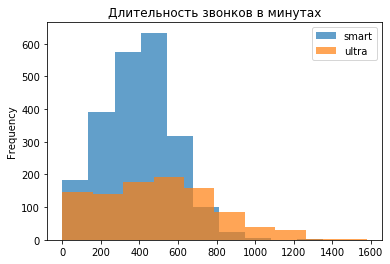

In [11]:
# Выведем гистограммы по минутам, израсходованному трафику и сообщениям.
data.groupby('tariff')['duration'].plot(kind='hist', title='Длительность звонков в минутах', legend=True, alpha=0.7)

Есть скошенность влево на обоих графиках: медиана больше, чем среднее, и сильного разброса значений нет. Абоненты тарифа Ультра в месяц в среднем расходуют больше минут, чем абоненты тарифа Смарт, и пик значений гораздо менее ярко выражен, более ровное распределение.

tariff
smart    AxesSubplot(0.125,0.125;0.775x0.755)
ultra    AxesSubplot(0.125,0.125;0.775x0.755)
Name: mb_used, dtype: object

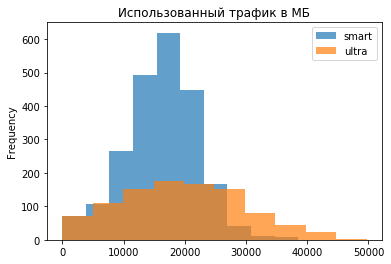

In [12]:
data.groupby('tariff')['mb_used'].plot(kind='hist', title='Использованный трафик в МБ', legend=True, alpha=0.7)

Данные для тарифа Смарт скошены влево, для тарифа Ультра же вправо. Абоненты тарифа Ультра расходуют больше трафика, чем абоненты тарифа Смарт.

tariff
smart    AxesSubplot(0.125,0.125;0.775x0.755)
ultra    AxesSubplot(0.125,0.125;0.775x0.755)
Name: messages_count, dtype: object

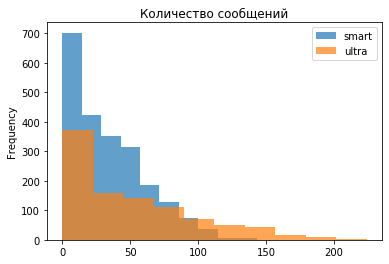

In [13]:
data.groupby('tariff')['messages_count'].plot(kind='hist', title='Количество сообщений', legend=True, alpha=0.7)

Здесь же распределение сильно отличается от предыдущих графиков: пик значений приходится на наименьшее количество сообщений, и с увеличением количества сообщений уменьшается число людей, отправляющих много сообщений.

Проверим, хватает ли в среднем пользователям тарифов установленных лимитов.

In [14]:
# Делаем выборку для тарифов.
smart_data = data.query('tariff == "smart"')
ultra_data = data.query('tariff == "ultra"')

# Высчитываем среднее и сбросим "хвосты", переведя в int.
smart_duration_mean = smart_data['duration'].mean().astype('int')
ultra_duration_mean = ultra_data['duration'].mean().astype('int')

smart_traffic_mean = smart_data['mb_used'].mean().astype('int')
ultra_traffic_mean = ultra_data['mb_used'].mean().astype('int')

smart_messages_mean = smart_data['messages_count'].mean().astype('int')
ultra_messages_mean = ultra_data['messages_count'].mean().astype('int')

# Сохраним в переменных лимиты для тарифов.
smart_minutes_included = tariffs_data.loc[0, 'minutes_included']
smart_messages_included = tariffs_data.loc[0, 'messages_included']
smart_mb_per_month_included = tariffs_data.loc[0, 'mb_per_month_included']

ultra_minutes_included = tariffs_data.loc[1, 'minutes_included']
ultra_messages_included = tariffs_data.loc[1, 'messages_included']
ultra_mb_per_month_included = tariffs_data.loc[1, 'mb_per_month_included']

# Проверим, укладываются ли в лимиты абоненты.
if smart_duration_mean > smart_minutes_included:
    print('Пользователям тарифа Смарт не хватает включённых минут.')
else:
    print('Пользователям тарифа Смарт хватает включённых минут.')
    
if smart_messages_mean > smart_messages_included:
    print('Пользователям тарифа Смарт не хватает включённых сообщений.')
else:
    print('Пользователям тарифа Смарт хватает включённых сообщений.')
    
if smart_traffic_mean > smart_mb_per_month_included:
    print('Пользователям тарифа Смарт не хватает включённого трафика.')
else:
    print('Пользователям тарифа Смарт хватает включённого трафика.')
    
if ultra_duration_mean > ultra_minutes_included:
    print('Пользователям тарифа Ультра не хватает включённых минут.')
else:
    print('Пользователям тарифа Ультра хватает включённых минут.')
    
if ultra_messages_mean > ultra_messages_included:
    print('Пользователям тарифа Ультра не хватает включённых сообщений.')
else:
    print('Пользователям тарифа Ультра хватает включённых сообщений.')
    
if ultra_traffic_mean > ultra_mb_per_month_included:
    print('Пользователям тарифа Ультра не хватает включённого трафика.')
else:
    print('Пользователям тарифа Ультра хватает включённого трафика.')

Пользователям тарифа Смарт хватает включённых минут.
Пользователям тарифа Смарт хватает включённых сообщений.
Пользователям тарифа Смарт не хватает включённого трафика.
Пользователям тарифа Ультра хватает включённых минут.
Пользователям тарифа Ультра хватает включённых сообщений.
Пользователям тарифа Ультра хватает включённого трафика.


Как можно заметить, в среднем пользователи укладываются в лимиты, за исключением трафика в тарифе Smart.

Посчитаем, во скольки случаях абоненты платят сверх ежемесячной оплаты за тариф.

In [15]:
# Считаем общее количество абонентов и тех, кто заплатил выше ежемесячной оплаты.
smart_count = len(data.query('tariff == "smart"'))
smart_count_over = len(data.query('tariff == "smart" and payed_for_month > 550'))
smart_percent = smart_count_over / smart_count
                  
ultra_count = len(data.query('tariff == "ultra"'))
ultra_count_over = len(data.query('tariff == "ultra" and payed_for_month > 1950'))
ultra_percent = ultra_count_over / ultra_count
print(f"Количество переплативших на тарифе Смарт: {smart_percent:.2%} и на тарифе Ультра: {ultra_percent:.2%}")

Количество переплативших на тарифе Смарт: 73.03% и на тарифе Ультра: 13.74%


Оказалось, что на тарифе Смарт пользователи платят сверх стоимости тарифа гораздо чаще, чем на тарифе Ультра.

#### Вывод
Судя по графикам, тарифом Ультра, как более дорогим, пользуется меньше абонентов, чем тарифом Смарт, но при этом на Смарте переплачивают гораздо чаще, чем на Ультра. И в среднем пользователям Смарт не хватает включённого в тариф трафика, так как среднее значение трафика превышает таковое у лимита. В тарифе Ультра же расход минут, сообщений и трафика в среднем больше, но из-за больших лимитов, абоненты с Ультра переплачивают гораздо реже.

### <a id='step-4'>Шаг 4. Проверка гипотез.</a>

Необходимо выяснить, различается средняя ли выручка между двумя тарифами. Найдём среднюю выручку и затем проверим гипотезу о том, что средняя выручка пользователей тарифов Ультра» и «Смарт различается.

In [16]:
# Делаем выборку для прибыли двух тарифов.
smart_money = data.query('tariff == "smart"')['payed_for_month']
ultra_money = data.query('tariff == "ultra"')['payed_for_month']

# Найдём среднюю выручку по тарифам.
smart_money_mean = smart_money.mean()
ultra_money_mean = ultra_money.mean()

print(f'Средняя выручка для тарифа Смарт: {int(smart_money_mean)}')
print(f'Средняя выручка для тарифа Ультра: {int(ultra_money_mean)}')

Средняя выручка для тарифа Смарт: 1207
Средняя выручка для тарифа Ультра: 2063


Выручка различается, и достаточно сильно. Посмотрим значение в процентах.

In [17]:
print(f'Средняя выручка различается на {ultra_money_mean / smart_money_mean - 1:.2%}')

Средняя выручка различается на 70.82%


Определим, схожи ли дисперсии выборок и соответственно, схожи ли они по параметрам.

In [18]:
# Ищем дисперсию.
smart_money_var = np.var(smart_money)
ultra_money_var = np.var(ultra_money)

print(f'Дисперсия для тарифа "Смарт: {int(smart_money_var)}')
print(f'Дисперсия для тарифа "Ультра: {int(ultra_money_var)}')

Дисперсия для тарифа "Смарт: 610809
Дисперсия для тарифа "Ультра: 132176


Проверим нашу гипотезу. За нулевую гипотезу возьмём утверждение, что средняя выручка двух тарифов примерно равна. В качестве же альтернативной гипотезы возьмём обратное утверждение, что средняя выручка между тарифами различается. Посмотрим, не противоречит ли результат гипотезе.

In [19]:
# Выставляем пороговое значение alpha. Отвергаем гипотезу, если p-значение меньше alpha.
alpha = .05

# Сопоставим средние генеральных совокупностей. Так как дисперсии 
# различаются достаточно сильно, для метода выставим equal_var равным False.
results = st.ttest_ind(ultra_money, smart_money, equal_var=False)

# Вычисляем p-значение.
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  4.0045569176774e-310
Отвергаем нулевую гипотезу


Нулевая гипотеза (средняя выручку равна) была отвергнута, 

Необходимо выяснить, различается ли средняя выручка пользователей из Москвы от выручки пользователей из других городов. За нулевую гипотезу возьмём утверждение, что выручка двух тарифов не отличается, за альтернативную гипотезу же возьмём утверждение о неравенстве выручки.

In [20]:
moscow_money = data.query('city in "Москва"')['payed_for_month']
not_moscow_money = data.query('city not in "Москва"')['payed_for_month']

moscow_money_mean = moscow_money.mean()
not_moscow_money_mean = not_moscow_money.mean()
moscow_money_var = np.var(moscow_money)
not_moscow_money_var = np.var(not_moscow_money)
print(f'Средняя выручка для Москвы: {moscow_money_mean}')
print(f'Средняя выручка для остальных городов: {not_moscow_money_mean}')
print(f'Дисперсия для Москвы: {moscow_money_var}')
print(f'Дисперсия для остальных городов: {not_moscow_money_var}')

Средняя выручка для Москвы: 1491.520458265139
Средняя выручка для остальных городов: 1462.5447530864199
Дисперсия для Москвы: 553390.8093195936
Дисперсия для остальных городов: 635568.3976885192


Дисперсия различается ощутимо, для метода ttest_ind выставим equal_var равным False.

In [21]:
# Сопоставим средние генеральных совокупностей.
results = st.ttest_ind(moscow_money, not_moscow_money, equal_var=False)

# Вычисляем p-значение.
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.3935816533637607
Не получилось отвергнуть нулевую гипотезу


#### Вывод
В случае со средней выручкой между двумя тарифами можно утверждать, что среднее между двумя генеральными совокупностями различается, и вероятность этого достаточно высока. Но в случае со средней выручкой между Москвой и другими городами, у нас не получилось отвергнуть нулевую гипотезу, выручка почти не различается.

### <a id='step-5'>Шаг 5. Общий вывод.</a>

Как было показано, выручка между тарифами различается, причём достаточно сильно. Хотя средняя выручка выше у тарифа Ультра (2063 рублей против 1207 у тарифа Смарт), как и активность в целом: чаще пользуются звонками, сообщениями, Интернетом, пользователи Смарт гораздо чаще выходят за пределы лимитов и в результате платят гораздо больше, чем должны, тогда как в случае с Ультра разница далеко не такая сильная. Переплата у Смарт превышает саму стоимость тарифа более чем в два раза (550 рублей), в то время как на тарифе Ультра переплата всего лишь около 6%! Вывод: тариф Смарт выгоднее для компании.